# Urban Demography - Demographic Processing

- Author: Andrew Zimmer 
- Date Created: 2024-11-14 
- Last Edited:  2024-11-14 
- Version: 1.0

Description: 
- This script processes and analyzes urban demographic metrics, including population change, migration, fertility rates, and death rates. 
- It calculates key demographic indicators for urban centers, with estimates for migration flows, natural population change, and births.

Input Files:
- './Data/Urban-AgeSex-Output/Merged/merged_population_zonal_stats.csv'
- './Data/Niva-Data/Extract/death_rate_mean_zonal_stats.csv'
- './Data/Urban-Boundaries/GHS_UCDB_MTUC_GLOBE_R2024A.csv'
- './Data/Urban-Boundaries/GHS-MTUC-GPS.csv'

Output Files:
- './Data/Final-Datasets/GUDD-AnnualMetrics.csv': Final dataset with calculated metrics

Steps in Script
- Reads in multiple CSV files from a specified folder.
- Merges them into one DataFrame.
- Pivot the data to create a structured table with sex-age group keys as columns.
- Saves the final dataset to a CSV file.


In [1]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.stats import pearsonr

# data folder
data_folder = '../01_data/'

# 01 - loading zonal pop data

In [2]:
# load the merged population zonal stats data for all years (STATIC BOUNDARIES)
urbandem_all = pd.read_csv(Path(data_folder) / '01_urban_agesex_output/01_static_boundaries/02_merged/static_boundaries_merged_population_zonal_stats.csv')
urbandem_all.head()

,ID_UC_G0,year,f_00,f_01,f_05,f_10,f_15,f_20,f_25,f_30,...,m_35,m_40,m_45,m_50,m_55,m_60,m_65,m_70,m_75,m_80
0,4.0,2000,405.537598,1449.473022,1911.421753,2202.497314,1899.286865,1375.843384,1620.346436,1679.381592,...,1623.954224,1271.548096,1148.230591,763.847168,704.976196,508.520874,381.103638,221.381210,127.581169,67.398300
1,4.0,2001,388.214203,1445.518799,1793.382568,2090.650635,1896.937866,1397.760376,1511.245605,1614.958618,...,1611.648438,1272.296143,1133.591797,782.890747,682.015015,513.836121,376.235199,227.758636,128.931900,72.189232
2,4.0,2002,356.174438,1376.175903,1678.321533,1926.586670,1850.975952,1412.641602,1384.213379,1524.123047,...,1566.840210,1261.569092,1084.598145,805.373901,638.226562,516.326477,363.467590,231.297577,126.365288,76.206161
3,4.0,2003,375.103851,1500.086792,1862.544922,2054.859375,2101.829590,1657.091797,1500.743774,1672.365356,...,1771.725098,1462.478027,1209.397949,970.113098,697.817993,605.684326,411.891571,272.459412,145.344513,91.805191
4,4.0,2004,329.090027,1361.422241,1741.795166,1834.498657,1981.215942,1600.691528,1393.284302,1526.346436,...,1662.898438,1409.974121,1139.146118,960.718323,651.504150,585.504150,395.696991,265.062378,141.710510,90.275955


# 02 - loading and cleaning death rate data

In [3]:
# load ghs iso code data for merging
ghs_iso = pd.read_csv(Path(data_folder) / '03_ghs_ucdb/GHS-MTUC-GPS_with_iso.csv')
ghs_iso.head()

,ID_UC_G0,latitude,longitude,country_iso
0,4,-17.555923,-149.581676,PYF
1,5,32.368669,-117.055235,MEX
2,6,48.446964,-123.352429,CAN
3,7,14.909535,-92.057875,GTM
4,8,13.932219,-89.847549,SLV


In [4]:
# load the niva death rate data
deathrate_niva = pd.read_csv(Path(data_folder) / '02_auxiliary_data/01_niva_deathrate/01_static_boundaries/static_boundaries_death_rate_mean_zonal_stats.csv')
deathrate_niva.columns = ["ID_UC_G0", "year", "death_rate"]

# merge in the iso code for each ID_UC_G0 into the niva death rate data
deathrate_niva = deathrate_niva.merge(ghs_iso[['ID_UC_G0', 'country_iso']], on='ID_UC_G0', how='left')
deathrate_niva.head()

,ID_UC_G0,year,death_rate,country_iso
0,4.0,2000,4.559418,PYF
1,5.0,2000,3.199375,MEX
2,6.0,2000,7.402740,CAN
3,7.0,2000,6.093838,GTM
4,8.0,2000,6.577894,SLV


In [5]:
# load world bank death rate data (for 2020, since niva data only goes to 2019)
deathrate_wb = pd.read_csv(Path(data_folder) / '02_auxiliary_data/02_wb_deathrate/wb_deathrate_2020.csv')
deathrate_wb.head()

,country_iso,year,death_rate
0,ABW,2020,6.842000
1,AFE,2020,7.540022
2,AFG,2020,7.565000
3,AFW,2020,10.449272
4,AGO,2020,7.628000


In [6]:
# merge the niva and wb data together so we have a full set of death raters for 2000-2020 for every city
deathrate_2020_rows = deathrate_wb.copy()
deathrate_2020_rows["ID_UC_G0"] = pd.NA
deathrate_2020_rows = deathrate_2020_rows[deathrate_niva.columns]  # ensure same columns

# append and build a new df
deathrate_full = pd.concat([deathrate_niva, deathrate_2020_rows], ignore_index=True)
deathrate_full.head()

,ID_UC_G0,year,death_rate,country_iso
0,4.0,2000,4.559418,PYF
1,5.0,2000,3.199375,MEX
2,6.0,2000,7.402740,CAN
3,7.0,2000,6.093838,GTM
4,8.0,2000,6.577894,SLV


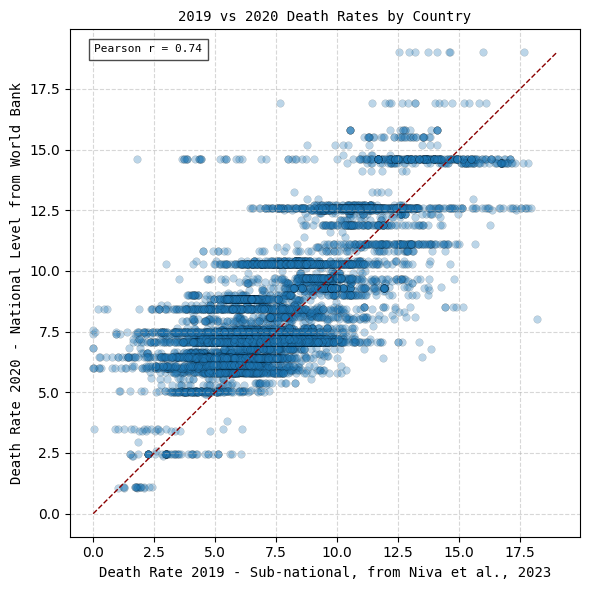

In [7]:
# quick plot of 2019 v 2020 death rates to see how they compare (niva sub-national 2019 vs wb national 2020)

# Filter 2020 and 2019 rows
deathrate_2020 = deathrate_full[deathrate_full["year"] == 2020]
deathrate_2019 = deathrate_full[deathrate_full["year"] == 2019]

# Merge on country_iso
merged = deathrate_2019.merge(
    deathrate_2020[["country_iso", "death_rate"]],
    on="country_iso",
    suffixes=("_2019", "_2020")
)

# Compute Pearson correlation
corr, pval = pearsonr(merged["death_rate_2019"], merged["death_rate_2020"])

# Simple linear regression for R² (optional)
slope, intercept = np.polyfit(merged["death_rate_2019"], merged["death_rate_2020"], 1)
r2 = np.corrcoef(merged["death_rate_2019"], merged["death_rate_2020"])[0,1]**2

# Font
font_prop = font_manager.FontProperties(family="DejaVu Sans Mono")

# Figure
plt.figure(figsize=(6, 6))

# Scatter points
plt.scatter(merged["death_rate_2019"], merged["death_rate_2020"], alpha=0.3, color='tab:blue', edgecolor='k', linewidths=0.2, s=30)

# 1:1 reference line
min_val = min(merged["death_rate_2019"].min(), merged["death_rate_2020"].min())
max_val = max(merged["death_rate_2019"].max(), merged["death_rate_2020"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='darkred', linestyle='--', linewidth=1, label='1:1 line')

# Labels and title
plt.xlabel("Death Rate 2019 - Sub-national, from Niva et al., 2023", fontproperties=font_prop, fontsize=10)
plt.ylabel("Death Rate 2020 - National Level from World Bank", fontproperties=font_prop, fontsize=10)
plt.title("2019 vs 2020 Death Rates by Country", fontproperties=font_prop, fontsize=10)

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate correlation
plt.text(0.05, 19,
         f"Pearson r = {corr:.2f}", 
         fontproperties=font_prop, fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()


# 03 - loading useful ghs-ucdb data

In [8]:
# get gps locations for each city
ghs_gps = pd.read_csv(Path(data_folder) / '03_ghs_ucdb/GHS-MTUC-GPS.csv')
ghs_gps.head()

,ID_UC_G0,latitude,longitude
0,4,-17.555923,-149.581676
1,5,32.368669,-117.055235
2,6,48.446964,-123.352429
3,7,14.909535,-92.057875
4,8,13.932219,-89.847549


In [9]:
# file path
ghs_info_path = Path(data_folder) / '03_ghs_ucdb/GHS_UCDB_MTUC_GLOBE_R2024A.csv'

# Columns to read
cols_to_use = [
    "ID_MTUC_G0",
    "GC_UCN_MAI_2025",
    "GC_CNT_GAD_2025",
    "GC_DEV_USR_2025",
    "GC_DEV_WIG_2025",
    "GC_UCB_YOB _2025",
    "GC_UCB_YOD _2025"]

# read only these columns
ghs_ucdb_useful = pd.read_csv(ghs_info_path, usecols=cols_to_use, encoding='latin-1')

# rename columns
ghs_ucdb_useful.rename(columns={
    "ID_MTUC_G0": "ID_UC_G0",
    "GC_UCN_MAI_2025": "Name",
    "GC_CNT_GAD_2025": "Country",
    "GC_DEV_USR_2025": "Continent",
    "GC_DEV_WIG_2025": "Development",
    "GC_UCB_YOB _2025": "YearOfBirth",
    "GC_UCB_YOD _2025": "YearOfDeath"
}, inplace=True)

ghs_ucdb_useful.head()

,ID_UC_G0,Name,Country,Continent,Development,YearOfBirth,YearOfDeath
0,1,Apia,Samoa,Oceania,Lower Middle,2025,2030
1,2,Nuku'alofa,Tonga,Oceania,Upper Middle,2025,2030
2,3,Ewa Beach,United States,Northern America,High income,2025,2030
3,4,Papeete,French Polynesia,Oceania,High income,1980,2030
4,5,Rosarito,México,Latin America and the Caribbean,Upper Middle,2015,2030


In [10]:
# merge in the gps coordinates to the useful data
ghs_ucdb_useful = ghs_ucdb_useful.merge(ghs_gps[['ID_UC_G0', 'latitude', 'longitude']], on='ID_UC_G0', how='left')
ghs_ucdb_useful.head()

,ID_UC_G0,Name,Country,Continent,Development,YearOfBirth,YearOfDeath,latitude,longitude
0,1,Apia,Samoa,Oceania,Lower Middle,2025,2030,NaN,NaN
1,2,Nuku'alofa,Tonga,Oceania,Upper Middle,2025,2030,NaN,NaN
2,3,Ewa Beach,United States,Northern America,High income,2025,2030,NaN,NaN
3,4,Papeete,French Polynesia,Oceania,High income,1980,2030,-17.555923,-149.581676
4,5,Rosarito,México,Latin America and the Caribbean,Upper Middle,2015,2030,32.368669,-117.055235


In [11]:
# merge together this info with the city details, and then save
urbandem_all_details = urbandem_all.merge(ghs_ucdb_useful, on='ID_UC_G0', how='left')
urbandem_all_details.head()

,ID_UC_G0,year,f_00,f_01,f_05,f_10,f_15,f_20,f_25,f_30,...,m_75,m_80,Name,Country,Continent,Development,YearOfBirth,YearOfDeath,latitude,longitude
0,4.0,2000,405.537598,1449.473022,1911.421753,2202.497314,1899.286865,1375.843384,1620.346436,1679.381592,...,127.581169,67.398300,Papeete,French Polynesia,Oceania,High income,1980.0,2030.0,-17.555923,-149.581676
1,4.0,2001,388.214203,1445.518799,1793.382568,2090.650635,1896.937866,1397.760376,1511.245605,1614.958618,...,128.931900,72.189232,Papeete,French Polynesia,Oceania,High income,1980.0,2030.0,-17.555923,-149.581676
2,4.0,2002,356.174438,1376.175903,1678.321533,1926.586670,1850.975952,1412.641602,1384.213379,1524.123047,...,126.365288,76.206161,Papeete,French Polynesia,Oceania,High income,1980.0,2030.0,-17.555923,-149.581676
3,4.0,2003,375.103851,1500.086792,1862.544922,2054.859375,2101.829590,1657.091797,1500.743774,1672.365356,...,145.344513,91.805191,Papeete,French Polynesia,Oceania,High income,1980.0,2030.0,-17.555923,-149.581676
4,4.0,2004,329.090027,1361.422241,1741.795166,1834.498657,1981.215942,1600.691528,1393.284302,1526.346436,...,141.710510,90.275955,Papeete,French Polynesia,Oceania,High income,1980.0,2030.0,-17.555923,-149.581676


# 04 - save GUDD ALL

In [12]:
urbandem_all_details.to_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_all_static_boundaries.csv', index=False)

# 05 - calculate total population counts for different groups

In [13]:
# define age groups for computing demographic metrics
f_ages = ["f_00", "f_01", "f_05", "f_10", "f_15", "f_20", "f_25", "f_30", "f_35", "f_40",
          "f_45", "f_50", "f_55", "f_60", "f_65", "f_70", "f_75", "f_80"]
m_ages = ["m_00", "m_01", "m_05", "m_10", "m_15", "m_20", "m_25", "m_30", "m_35", "m_40",
          "m_45", "m_50", "m_55", "m_60", "m_65", "m_70", "m_75", "m_80"]

# young, working, old, women, children, birth columns
young_f = ["f_00", "f_01", "f_05", "f_10"]
young_m = ["m_00", "m_01", "m_05", "m_10"]
working_f = ["f_15", "f_20", "f_25", "f_30", "f_35", "f_40", "f_45", "f_50", "f_55", "f_60"]
working_m = ["m_15", "m_20", "m_25", "m_30", "m_35", "m_40", "m_45", "m_50", "m_55", "m_60"]
old_f = ["f_65", "f_70", "f_75", "f_80"]
old_m = ["m_65", "m_70", "m_75", "m_80"]
women_cba = ["f_15", "f_20", "f_25", "f_30", "f_35", "f_40", "f_45"]
child_f = ["f_00", "f_01"]
child_m = ["m_00", "m_01"]
births = ["f_00", "m_00"]

# compute metrics
urbandem_metrics = urbandem_all_details.copy()

# total population
urbandem_metrics["total_pop"] = urbandem_metrics[f_ages + m_ages].sum(axis=1)
urbandem_metrics["total_pop_f"] = urbandem_metrics[f_ages].sum(axis=1)
urbandem_metrics["total_pop_m"] = urbandem_metrics[m_ages].sum(axis=1)

# young population
urbandem_metrics["young_pop"] = urbandem_metrics[young_f + young_m].sum(axis=1)
urbandem_metrics["young_pop_f"] = urbandem_metrics[young_f].sum(axis=1)
urbandem_metrics["young_pop_m"] = urbandem_metrics[young_m].sum(axis=1)

# working-age population
urbandem_metrics["working_pop"] = urbandem_metrics[working_f + working_m].sum(axis=1)
urbandem_metrics["working_pop_f"] = urbandem_metrics[working_f].sum(axis=1)
urbandem_metrics["working_pop_m"] = urbandem_metrics[working_m].sum(axis=1)

# old population
urbandem_metrics["old_pop"] = urbandem_metrics[old_f + old_m].sum(axis=1)
urbandem_metrics["old_pop_f"] = urbandem_metrics[old_f].sum(axis=1)
urbandem_metrics["old_pop_m"] = urbandem_metrics[old_m].sum(axis=1)

# women of child-bearing age
urbandem_metrics["women_cba"] = urbandem_metrics[women_cba].sum(axis=1)

# children under 2
urbandem_metrics["child_total"] = urbandem_metrics[child_f + child_m].sum(axis=1)

# total under 1 (births)
urbandem_metrics["births_total"] = urbandem_metrics[births].sum(axis=1)

urbandem_metrics.head()

,ID_UC_G0,year,f_00,f_01,f_05,f_10,f_15,f_20,f_25,f_30,...,young_pop_m,working_pop,working_pop_f,working_pop_m,old_pop,old_pop_f,old_pop_m,women_cba,child_total,births_total
0,4.0,2000,405.537598,1449.473022,1911.421753,2202.497314,1899.286865,1375.843384,1620.346436,1679.381592,...,6385.290131,24883.084961,12035.922974,12847.161987,1670.198296,872.733978,797.464317,10283.075684,3791.194305,822.882172
1,4.0,2001,388.214203,1445.518799,1793.382568,2090.650635,1896.937866,1397.760376,1511.245605,1614.958618,...,6103.931732,24523.537598,11877.967957,12645.569641,1683.364861,878.249893,805.114967,10115.636230,3738.709412,789.825989
2,4.0,2002,356.174438,1376.175903,1678.321533,1926.586670,1850.975952,1412.641602,1384.213379,1524.123047,...,5684.800568,23779.593628,11526.329041,12253.264587,1665.372307,868.035690,797.336617,9774.331787,3531.827667,727.828278
3,4.0,2003,375.103851,1500.086792,1862.544922,2054.859375,2101.829590,1657.091797,1500.743774,1672.365356,...,6158.501770,26938.335144,13063.598877,13874.736267,1922.489182,1000.988495,921.500687,11025.983521,3828.226837,770.736603
4,4.0,2004,329.090027,1361.422241,1741.795166,1834.498657,1981.215942,1600.691528,1393.284302,1526.346436,...,5593.771576,25480.884033,12363.558655,13117.325378,1859.684875,966.939041,892.745834,10388.108032,3458.252106,680.028351


# 06 - calculate demographic metrics

In [14]:
# dependency ratios
urbandem_metrics["total_dr"] = (urbandem_metrics["young_pop"] + urbandem_metrics["old_pop"]) / urbandem_metrics["working_pop"]
urbandem_metrics["young_dr"] = urbandem_metrics["young_pop"] / urbandem_metrics["working_pop"]
urbandem_metrics["old_dr"] = urbandem_metrics["old_pop"] / urbandem_metrics["working_pop"]

# sex ratios
urbandem_metrics["total_sr"] = urbandem_metrics["total_pop_m"] / urbandem_metrics["total_pop_f"]
urbandem_metrics["young_sr"] = urbandem_metrics["young_pop_m"] / urbandem_metrics["young_pop_f"]
urbandem_metrics["working_sr"] = urbandem_metrics["working_pop_m"] / urbandem_metrics["working_pop_f"]
urbandem_metrics["old_sr"] = urbandem_metrics["old_pop_m"] / urbandem_metrics["old_pop_f"]

#woman child ratio
urbandem_metrics["women_cr"] = (urbandem_metrics["child_total"] / urbandem_metrics["women_cba"]) * 1000

# 07 - calculate migration statistics

In [15]:
# merge in death rate and calculate deaths

urbandem_metrics["ID_UC_G0"] = urbandem_metrics["ID_UC_G0"].astype(str)
deathrate_full["ID_UC_G0"] = deathrate_full["ID_UC_G0"].astype(str)

urbandem_metrics = urbandem_metrics.merge(deathrate_full, on=["ID_UC_G0", "year"], how="left")

# Calculate deaths
urbandem_metrics["deaths_total"] = (urbandem_metrics["total_pop"] / 1000) * urbandem_metrics["death_rate"]


In [16]:
# population change
migration_calc = (urbandem_metrics[["ID_UC_G0", "year", "total_pop", "births_total", "deaths_total"]]
                     .sort_values(["ID_UC_G0", "year"])
                     .copy())

# Calculate pop_change (year-over-year difference) and lead the change
migration_calc["pop_change"] = migration_calc.groupby("ID_UC_G0")["total_pop"].diff()
migration_calc["pop_change"] = migration_calc.groupby("ID_UC_G0")["pop_change"].shift(-1)


In [17]:
# proportion of total pop born each year
migration_calc["births_proportion"] = migration_calc["births_total"] / migration_calc["total_pop"]

In [18]:
# initial calculation of migration
migration_calc["natural_change_initial"] = migration_calc["births_total"] - migration_calc["deaths_total"]
migration_calc["migration_initial"] = migration_calc["pop_change"] - migration_calc["natural_change_initial"]
migration_calc["migration_babies"] = migration_calc["migration_initial"] * migration_calc["births_proportion"]

In [19]:
# lag migration babies by 1 year
migration_calc["migration_babies_lag"] = migration_calc.groupby("ID_UC_G0")["migration_babies"].shift(1)

In [20]:
# calculate natural change
migration_calc["natural_change_final"] = migration_calc.apply(
    lambda row: row["births_total"] - row["deaths_total"] 
    if pd.isna(row["migration_babies_lag"]) 
    else row["births_total"] - (row["deaths_total"] + row["migration_babies_lag"]),
    axis=1
)


In [21]:
# final migration calculation including the impact of migration babies
migration_calc["migration_final"] = migration_calc["pop_change"] - migration_calc["natural_change_final"]

In [22]:
# final count of births, post-migration
migration_calc["births_final"] = migration_calc.apply(
    lambda row: row["births_total"] if pd.isna(row["migration_babies_lag"]) 
    else row["births_total"] - row["migration_babies_lag"],
    axis=1
)

In [23]:
# migration as a percentage of population change
migration_calc["migration_annual_perc"] = migration_calc["migration_final"] / migration_calc["pop_change"]

In [24]:
# keeping useful info
migration_calc_useful = migration_calc[["ID_UC_G0", "year", "pop_change", "migration_annual_perc"]].copy()
migration_calc_useful["natural_change"] = migration_calc["natural_change_final"]
migration_calc_useful["migration"] = migration_calc["migration_final"]
migration_calc_useful["births"] = migration_calc["births_final"]


In [25]:
# merge back in to urbandem_metrics
urbandem_metrics = urbandem_metrics.merge(migration_calc_useful, on=["ID_UC_G0", "year"], how="left")

In [26]:
# calculate general fertility rate, now we have births
urbandem_metrics["general_fr"] = (urbandem_metrics["births"] / urbandem_metrics["women_cba"]) * 1000

In [27]:
# select variables to keep for saving
cols_to_keep = [
    "ID_UC_G0", "year", "Name", "Country", "Continent", "Development", "YearOfBirth", "YearOfDeath",
    "latitude", "longitude",
    "total_pop", "total_pop_f", "total_pop_m",
    "young_pop", "young_pop_f", "young_pop_m",
    "working_pop", "working_pop_f", "working_pop_m",
    "old_pop", "old_pop_f", "old_pop_m",
    "women_cba",
    "total_dr", "young_dr", "old_dr",
    "total_sr", "young_sr", "working_sr", "old_sr",
    "women_cr", "general_fr",
    "death_rate", "deaths_total",
    "pop_change", "natural_change", "migration", "births",
    "migration_annual_perc"
]

urbandem_metrics_final = urbandem_metrics[cols_to_keep].copy()

urbandem_metrics_final.to_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv', index=False)